In [19]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# Let's set-up a simple spring-mass-damper model
def damper(x_dot, c):
    return c*x_dot

def gaussian_damper(x_dot, mean, var):
    """Sample the damping coefficient from a normal gaussian"""
    return x_dot * np.random.normal(mean, var)

def ode(t, y, friction_model, friction_kwargs):
    c = 1
    k = 20
    m = 1
    
    x1, x2 = y
    
    x1_dot = x2
    x2_dot = (-k*x1 - friction_model(x2, **friction_kwargs) - 9.81*m)/m
    
    return [x1_dot, x2_dot]

In [21]:
from scipy.integrate import solve_ivp

In [35]:
friction_model = damper
friction_kwargs = {'c': 1}
result = solve_ivp(lambda t,y: ode(t, y, friction_model, friction_kwargs),
                  [0, 5],
                  [0.11, 0],
                  max_step=0.01,
                  t_eval=np.linspace(0, 5, 1000))

In [36]:
t_actual = result.t
x_pos_actual = result.y[0, :]

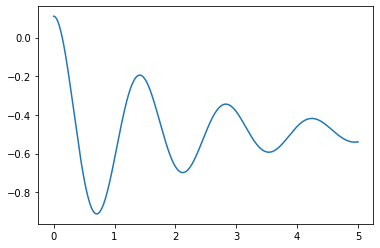

In [37]:
plt.plot(t_actual, x_pos_actual)

In [38]:
def generate_training_data(N=100):
    times = []
    x_poses = []
    for _ in range(N):
        mean = np.abs(np.random.normal(1, 0.1))
        var = np.abs(np.random.normal(0.1, 0.1))
        c = np.abs(np.random.normal(mean, var))
        friction_kwargs = {'c': c}
        result = solve_ivp(lambda t, y: ode(t, y, damper, friction_kwargs),
                          [0, 5],
                          [0.11, 0],
                          t_eval=np.linspace(0, 5, 1000))
        
        times.append(result.t)
        x_poses.append(result.y[0, :])
    return times, x_poses


In [39]:
times, x_poses = generate_training_data()

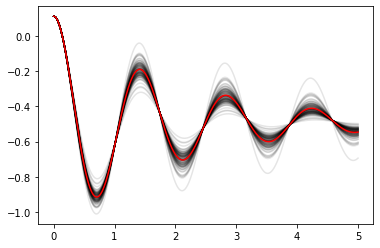

In [40]:
for t, x in zip(times, x_poses):
    plt.plot(t, x, 'k', alpha=0.1)
    
plt.plot(np.mean(times, axis=0), np.mean(x_poses, axis=0), 'r')

In [41]:
# Quick refamiliarization with nevergrad

In [99]:
import nevergrad as ng
import numpy as np

def square(x):
    return sum((x - .5)**2)


def squared(x, y):
    return x*x + y*y

In [102]:
instrumentation = ng.p.Instrumentation(x=ng.p.Scalar(lower=0), y=ng.p.Scalar(upper=3))
optimizer = ng.optimizers.OnePlusOne(parametrization=instrumentation, budget=100)
recommendation = optimizer.minimize(squared)
print(recommendation.value)

((), {'x': 0.0, 'y': 0.0})


In [44]:
len(x_pos_actual)

1000

In [108]:
from sklearn.metrics import mean_squared_error

def my_function(fric_mean, fric_var):
    N = 5
    errors = []
    for _ in range(N):
        result = solve_ivp(lambda t, y: ode(t, y, gaussian_damper, {'mean': fric_mean, 'var': fric_var}),
                          [0, 5],
                          [0.11, 0],
                          t_eval=np.linspace(0, 5, 1000))
        # Calculate loss
        error = mean_squared_error(result.y[0, :], x_pos_actual)
        errors.append(error)
    
    return np.mean(errors)  # Return mean error

In [119]:
def my_callback(optimizer, candidate, value):
    print(f'Values: {candidate.value} :: Loss: {value}')

In [121]:
instrumentation = ng.p.Instrumentation(fric_mean=ng.p.Scalar(lower=0), fric_var=ng.p.Scalar(lower=0))
optimizer = ng.optimizers.PSO(parametrization=instrumentation, budget=100)
optimizer.register_callback('tell', my_callback)
recommendation = optimizer.minimize(my_function)

Values: ((), {'fric_mean': 0.7603675391485467, 'fric_var': 0.09596082155816293}) :: Loss: 0.0013949969886425258
Values: ((), {'fric_mean': 1.6844397485859433, 'fric_var': 0.36083511534086954}) :: Loss: 0.003954904361529775
Values: ((), {'fric_mean': 0.48113994055354875, 'fric_var': 0.5110003599630818}) :: Loss: 0.009439069073893209
Values: ((), {'fric_mean': 1.0986359739254319, 'fric_var': 0.06251944980807271}) :: Loss: 0.00013260256145114702
Values: ((), {'fric_mean': 0.2353390023116778, 'fric_var': 0.9182489880963092}) :: Loss: 0.025256605545990324
Values: ((), {'fric_mean': 0.4300188964903912, 'fric_var': 0.32884517299647437}) :: Loss: 0.013514307218449257
Values: ((), {'fric_mean': 1.2442502081957956, 'fric_var': 1.527051160985543}) :: Loss: 0.0014796623998362094
Values: ((), {'fric_mean': 0.8113805895540331, 'fric_var': 0.8337556668362409}) :: Loss: 0.0010012048458440405
Values: ((), {'fric_mean': 0.05465472160795757, 'fric_var': 2.1698139640392036}) :: Loss: 0.04596845790664376
V

KeyboardInterrupt: 

In [112]:
recommendation.value

((), {'fric_mean': 0.9602687089341999, 'fric_var': 2.331334696065414})